In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px

In [33]:
def load_data_from_sqlite(db_path):
   
    conn = sqlite3.connect(db_path) 
    
    query = """
    SELECT name, property_type, street, ward, district, 
           price_total, price_m2, area, long as longitude, lat as latitude
    FROM real_estate_processed
    WHERE price_total > 0 AND area > 0 AND long IS NOT NULL AND lat IS NOT NULL
    """
    
    df = pd.read_sql(query, conn)
    conn.close()
    
    return df

DB_PATH = '../data_real_estate.db'
df = load_data_from_sqlite(DB_PATH)

In [34]:
# print(f"Số bản ghi ban đầu: {len(df)}")
# 
# # Lọc các giá trị không hợp lý
# df = df[(df['price_total'] > 100e6) & (df['price_total'] < 500e9)]  # Giá từ 100 triệu đến 500 tỷ
# df = df[(df['area'] >= 10)]  # Diện tích từ 10 m2
# 
# print(f"Số bản ghi sau khi lọc: {len(df)}")

In [35]:
# Kiểm tra và xử lý giá trị thiếu (nếu có)
df = df.dropna()

# Chọn các cột số để clustering
data = df[['price_total', 'price_m2', 'area', 'longitude', 'latitude']].values

In [36]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

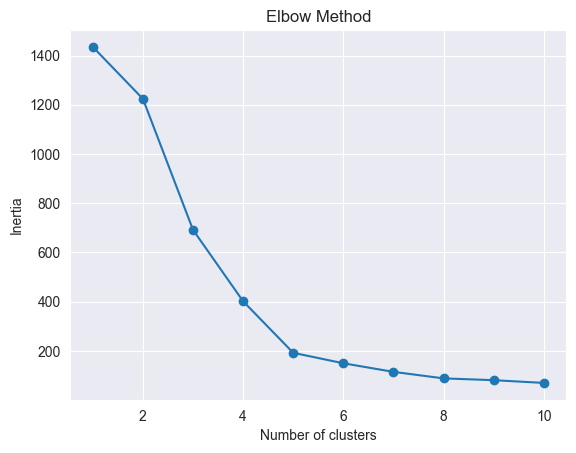

In [37]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [38]:
# Khởi tạo và huấn luyện mô hình K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=42)

In [39]:
# Lấy nhãn cụm và tâm cụm
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [40]:
# Thêm nhãn cụm vào DataFrame
df['cluster'] = labels

In [41]:
# In số lượng bất động sản trong mỗi cụm
print("Số lượng bất động sản trong mỗi cụm:")
print(df['cluster'].value_counts())
print(pd.DataFrame(df, columns=['name', 'price_total', 'cluster']))

Số lượng bất động sản trong mỗi cụm:
cluster
0    284
1      2
2      1
Name: count, dtype: int64
                                                  name   price_total  cluster
0    Bán 102m2 đất view công viên đường Đông Trà 8,...  3.850000e+09        0
1    1 lô duy nhất! Lô đất vip phường Hòa Xuân, Cẩm...  2.500000e+09        0
2    Hàng đẹp! 2 lô liền kề đường Nguyễn Văn Tỵ, đi...  2.880000e+09        0
3    Chào bán giá gốc phân khu V6 đẹp nhất KĐT FPT ...  4.690000e+09        0
4    Chính chủ chào bán nhà 2 mặt tiền ngay bãi tắm...  9.000000e+09        0
..                                                 ...           ...      ...
282  Bán lô Khuê Mỹ đoạn nhà Máy Cao Su Lê Văn Hiến...  1.020000e+10        0
283  Tôi chính chủ - cần bán gấp nhà 4 tầng đã hoàn...  1.450000e+10        0
284  Bán đất mặt tiền đường Lê Kim Lăng (lề 10m5) s...  5.600000e+09        0
285  Chính chủ bán 373m2 Bà Huyện Thanh Quan, phố s...  3.000000e+10        0
286  Siêu hiếm nhà đẹp mặt tiền Ngô Quyền kẹ

In [42]:
# In thông tin tâm cụm (đã chuẩn hóa)
print("\nTâm cụm (centroids) trong không gian chuẩn hóa:")
print(pd.DataFrame(centroids, columns=['price_total', 'price_m2', 'area', 'longitude', 'latitude']))


Tâm cụm (centroids) trong không gian chuẩn hóa:
   price_total  price_m2      area  longitude   latitude
0    -0.069100 -0.021569  0.000249  -0.058994   0.054505
1     9.726368  3.187923 -0.009256   0.004769   0.168273
2     0.171708 -0.250361 -0.052083  16.744687 -15.815917


In [46]:
from IPython.display import display

# Tạo bản đồ
m = folium.Map(location=[16.05, 108.21], zoom_start=12, tiles='OpenStreetMap')

# CSS tùy chỉnh cho popup
popup_style = """
<style>
    .leaflet-popup-content {
        width: 300px !important;
        padding: 10px;
        font-family: Arial, sans-serif;
        line-height: 1.5;
    }
    .leaflet-popup-content b {
        color: #2c3e50;
    }
    .leaflet-popup-content div {
        margin-bottom: 5px;
    }
</style>
"""
# Tạo layer cho từng quận
districts = sorted(df['district'].unique())
colors = {0: 'blue', 1: 'green', 2: 'purple'}

for district in districts:
    # Tạo FeatureGroup cho quận
    fg = folium.FeatureGroup(name=district, show=False)  # Mặc định ẩn
    # Lọc dữ liệu theo quận
    district_df = df[df['district'] == district]
    # Thêm markers
    for idx, row in district_df.iterrows():
        popup_content = (
            f"{popup_style}"
            f"<div><b>Tên:</b> {row['name']}</div>"            
            f"<div><b>Diện tích:</b> {row['area']}</div>"
            f"<div><b>Giá/m2:</b> {row['price_m2']}</div>"
            f"<div><b>Giá:</b> {row['price_total']}</div>"
            f"<div><b>Quận:</b> {row['district']}</div>"
            f"<div><b>Cụm:</b> {row['cluster']}</div>"
        )
        folium.CircleMarker(
            location=[row['longitude'], row['latitude']],
            radius=6,
            color=colors[row['cluster']],
            fill=True,
            fill_color=colors[row['cluster']],
            fill_opacity=0.7,
            popup=folium.Popup(popup_content, max_width=300)
        ).add_to(fg)
    fg.add_to(m)

# Thêm layer tất cả
fg_all = folium.FeatureGroup(name='Tất cả', show=True)  # Mặc định hiển thị
for idx, row in df.iterrows():
    popup_content = (
        f"{popup_style}"
        f"<div><b>Tên:</b> {row['name']}</div>"            
        f"<div><b>Diện tích:</b> {row['area']}</div>"
        f"<div><b>Giá/m2:</b> {row['price_m2']}</div>"
        f"<div><b>Giá:</b> {row['price_total']}</div>"
        f"<div><b>Quận:</b> {row['district']}</div>"
        f"<div><b>Cụm:</b> {row['cluster']}</div>"
    )
    folium.CircleMarker(
        location=[row['longitude'], row['latitude']],
        radius=6,
        color=colors[row['cluster']],
        fill=True,
        fill_color=colors[row['cluster']],
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(fg_all)
fg_all.add_to(m)

# Thêm LayerControl
folium.LayerControl(collapsed=False).add_to(m)

# Lưu bản đồ
m.save('real_estate_district_map.html')
display(m)
print("real_estate_district_map.html")

real_estate_district_map.html


In [48]:

import ipywidgets as widgets
from ipywidgets import interact

# Hàm vẽ bản đồ và biểu đồ
def plot_map_and_chart(district='all'):
    # Lọc dữ liệu theo quận
    if district == 'all':
        filtered_df = df
    else:
        filtered_df = df[df['district'] == district]
    
    # Tính số lượng bất động sản theo cụm
    cluster_counts = filtered_df['cluster'].value_counts().reindex([0, 1, 2], fill_value=0).sort_index()
    
    # Vẽ biểu đồ
    plt.figure(figsize=(8, 4))
    bars = plt.bar(['Cụm 0', 'Cụm 1', 'Cụm 2'], cluster_counts, color=['#3498db', '#2ecc71', '#9b59b6'])
    plt.title(f'Số lượng bất động sản theo cụm ({district})')
    plt.xlabel('Cụm')
    plt.ylabel('Số lượng')
    plt.ylim(0, max(cluster_counts.max() + 1, 5))  # Đảm bảo tỷ lệ hợp lý
    
    # Thêm giá trị trên cột
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')
    
    plt.tight_layout()
    
    plt.show()

# Tạo dropdown
districts = ['all'] + sorted(df['district'].unique())
interact(plot_map_and_chart, district=widgets.Dropdown(options=districts, value='all', description='Quận:'))

interactive(children=(Dropdown(description='Quận:', options=('all', 'Cẩm Lệ', 'Hòa Vang', 'Hải Châu', 'Liên Ch…

<function __main__.plot_map_and_chart(district='all')>